# Bayesian Priors

- Bayesian Experimentation methods for products: https://towardsdatascience.com/bayesian-experimentation-methods-for-products-636514951e43
- Part 1: Conversions: https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec
- Part 2: Revenue: https://towardsdatascience.com/bayesian-ab-testing-part-ii-revenue-1fbcf04f96cd
- Part 3: Test Duration: https://towardsdatascience.com/bayesian-ab-testing-part-iii-test-duration-f2305215009c
- Part 4: Choosing Priors: https://towardsdatascience.com/bayesian-ab-testing-part-iv-choosing-a-prior-5a4fe3223bfd
- Github Repo: https://github.com/ksureshkumar-loveshark/blogs_public/tree/main/Bayesian%20AB%20Testing

## Introduction

***
**Bayesian AB Testing Advantages**

- Benefits
    - Test duration
    - Explanation w/non technical
    - Errors & mistakes
- AB Test Questions
    - Treatment better than control?
    - Probability that treatment better than control?
    - Risk of using treatment over control?
- Frequentist
    - Probability of observing a conversion rate for the treatment group that is at least as high as the one in this given experiment. If that prob is less than 5% then we can be confident our conclusion isn't wrong
- Bayesian
    - We set a distribution, then update that distribution using the data, then sample from that end distribution
    - Calculate the prob treatment>control, prob treatment is a mistake, loss function which normalizes this error probability by the size of the error (larger penalized more than smaller)
    - Reach significance when expected loss function is less than threshold set initially
- Pros to Bayesian
    - frequentist approach only tells us what teh chances of making a mistake are and assumes all mistakes are equally costly - bayesian you can assign a cost to each mistake
    - Bayesian gives you probablity the treatment > control & expected loss of choosing wrongly
- Cons of bayesian
    - more complex calculations - but we got the computers to help
    - the idea of a prior - but we cna use conjugate priors like the last conversion rate from history

***
**Generate Historical Data**

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import gamma
import uuid

SAMPLE_SIZE = 5268
CONVERSION_PROBABILITY = 0.326
REVENUE_RATE = 2.0

if __name__ == "__main__":
    user_ids = [uuid.uuid4().hex for i in range(SAMPLE_SIZE)]
    conversion_flips = np.random.binomial(n=1, p=CONVERSION_PROBABILITY, size=SAMPLE_SIZE)

    data = pd.DataFrame()
    data['userId'] = user_ids
    data['converted'] = conversion_flips

    converted = data[data['converted'] == 1]
    no_of_conversions = converted.shape[0]
    revenue = np.random.exponential(scale=(1/REVENUE_RATE), size=no_of_conversions)
    converted['revenue'] = revenue

    rest = data[data['converted'] == 0]
    rest['revenue'] = 0

    data = pd.concat([converted, rest])
    data = data.sample(frac=1)
    data = data.round(decimals=2)

    data.to_csv('prior_data.csv', index=False)

C:\Users\wallj\AppData\Local\Temp\ipykernel_11368\2710266449.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converted['revenue'] = revenue
C:\Users\wallj\AppData\Local\Temp\ipykernel_11368\2710266449.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest['revenue'] = 0


***
**Generate Experiment Data**

In [16]:
import pandas as pd
import numpy as np
import uuid

CONTROL_SIZE = 2743
CONTROL_CONVERSION_PROBABILITY = 0.326

TREATMENT_SIZE = 2358
TREATMENT_CONVERSION_PROBABILITY = 0.345


if __name__ == "__main__":
    control_user_ids = [uuid.uuid4().hex for i in range(CONTROL_SIZE)]
    control_conversion_flips = np.random.uniform(0,1,CONTROL_SIZE)
    control_converted = [i <= CONTROL_CONVERSION_PROBABILITY for i in control_conversion_flips]
    
    control = pd.DataFrame()
    control['userId'] = control_user_ids
    control['group'] = 'control'
    control['converted'] = control_converted

    treatment_user_ids = [uuid.uuid4().hex for i in range(TREATMENT_SIZE)]
    treatment_conversion_flips = np.random.uniform(0,1,TREATMENT_SIZE)
    treatment_converted = [i <= TREATMENT_CONVERSION_PROBABILITY for i in treatment_conversion_flips]
    
    treatment = pd.DataFrame()
    treatment['userId'] = treatment_user_ids
    treatment['group'] = 'treatment'
    treatment['converted'] = treatment_converted

    results = pd.concat([control, treatment])
    results = results.sample(frac=1)
    results.to_csv('experiment_data.csv', index=False)

***
## Conversions

***
**Import historical data**

In [4]:
import pandas as pd

In [5]:
prior_data = pd.read_csv('prior_data.csv')

In [6]:
print(prior_data.head())
print(prior_data.shape)

                             userId  converted  revenue
0  33012dc4e1674db9b61a9e4c551d620f          0     0.00
1  cc1602ca771e4fa988406ee8c252a189          0     0.00
2  9844cc290fbd4c6a93941a091d069045          1     0.59
3  ab59486a391342f78c0dc62966f43f70          0     0.00
4  e000b9aed0474a958fb6e88af58ad366          0     0.00
(5268, 3)


In [7]:
conversion_rate = prior_data['converted'].sum()/prior_data.shape[0]

In [8]:
print(f'Prior Conversion Rate is {round(conversion_rate,3)}')

Prior Conversion Rate is 0.315


***
**Choosing a prior distribution**

In [9]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

In [12]:
beta_weak = beta(round(conversion_rate, 1)*10 + 1, 10 + 1 - round(conversion_rate, 1)*10)
beta_mid = beta(round(conversion_rate, 1)*50 + 1, 50 + 1 - round(conversion_rate, 1)*50)
beta_strong = beta(round(conversion_rate, 2)*100 + 1, 100 + 1 - round(conversion_rate, 2)*100)

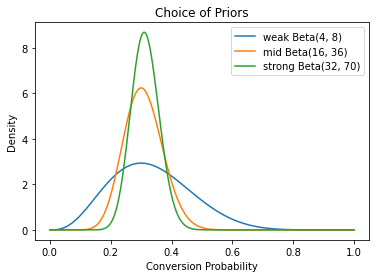

In [13]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(0,1,1000)
ax.plot(x, beta_weak.pdf(x), label=f'weak Beta({int(round(conversion_rate, 1)*10) + 1}, {10 + 1 - int(round(conversion_rate, 1)*10)})')
ax.plot(x, beta_mid.pdf(x), label=f'mid Beta({int(round(conversion_rate, 1)*50) + 1}, {50 + 1 - int(round(conversion_rate, 1)*50)})')
ax.plot(x, beta_strong.pdf(x), label=f'strong Beta({int(round(conversion_rate, 2)*100) + 1}, {100 + 1 - int(round(conversion_rate, 2)*100)})')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Choice of Priors')
ax.legend()

In [14]:
prior_alpha = round(conversion_rate, 1)*20 + 1
prior_beta = 20 + 1 - round(conversion_rate, 1)*20
prior = beta(prior_alpha, prior_beta)

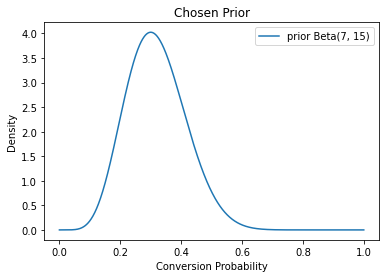

In [15]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(0,1,1000)
ax.plot(x, prior.pdf(x), label=f'prior Beta({int(round(conversion_rate, 1)*20) + 1}, {20 + 1 - int(round(conversion_rate, 1)*20)})')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Chosen Prior')
ax.legend()

***
**Loss Threshold**
- The highest expected loss we're willing to accpet in the case where we choose the wrong variant
    - If we don't want to lose more than 0.5%, the conversion rate of 30% * 0.5% would be 0.15

***
**Experiment Results**

In [17]:
experiment_data = pd.read_csv('experiment_data.csv')
print(experiment_data.head())
print(experiment_data.shape)

                             userId      group  converted
0  8932e4bee0a342e88452094ba28ca6c1  treatment      False
1  dce7390c9a394bab8f7de601f1ca3bdd    control       True
2  5a18d7fa835344c689d7206515a2014c    control      False
3  93f79ae942b54bf2a98e3193cdc69b60  treatment      False
4  6270bb758aec402e8a803cbd4af14c03  treatment       True
(5101, 3)


In [18]:
results = experiment_data.groupby('group').agg({'userId': pd.Series.nunique, 'converted': sum})
results.rename({'userId': 'sampleSize'}, axis=1, inplace=True)
results['conversionRate'] = results['converted']/results['sampleSize']
print(results)

           sampleSize  converted  conversionRate
group                                           
control          2743        933        0.340139
treatment        2358        806        0.341815


***
**Calculate Posterior**

In [19]:
control = beta(prior_alpha + results.loc['control', 'converted'], prior_beta + results.loc['control', 'sampleSize'] - results.loc['control', 'converted'])
treatment = beta(prior_alpha + results.loc['treatment', 'converted'], prior_beta + results.loc['treatment', 'sampleSize'] - results.loc['treatment', 'converted'])

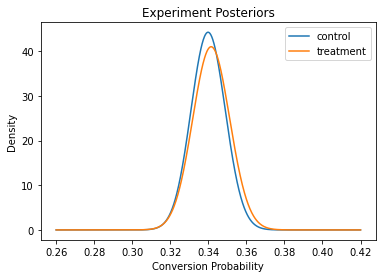

In [20]:
fig, ax = plt.subplots()
x = np.linspace(0.26,0.42,1000)
ax.plot(x, control.pdf(x), label='control')
ax.plot(x, treatment.pdf(x), label='treatment')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend()

***
**Join Posterior Distribution**

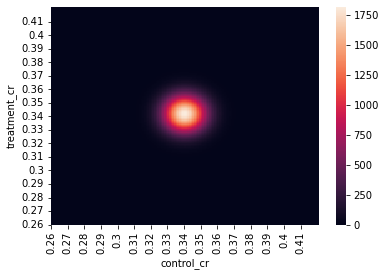

In [21]:
import seaborn as sns
joint_dist_for_plot = []
for i in np.linspace(0.26,0.42,161):
    for j in np.linspace(0.26,0.42,161):
        joint_dist_for_plot.append([i, j, control.pdf(i)*treatment.pdf(j)])
joint_dist_for_plot = pd.DataFrame(joint_dist_for_plot)
joint_dist_for_plot.rename({0: 'control_cr', 1: 'treatment_cr', 2: 'joint_density'}, axis=1, inplace=True)
tick_locations = range(0, 160, 10)
tick_labels = [round(0.26 + i*0.01, 2) for i in range(16)]
heatmap_df = pd.pivot_table(joint_dist_for_plot, values='joint_density', index='treatment_cr', columns='control_cr')
ax = sns.heatmap(heatmap_df)
ax.set_xticks(tick_locations)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_locations)
ax.set_yticklabels(tick_labels)
ax.invert_yaxis()

In [22]:
import decimal
decimal.getcontext().prec = 4
control_simulation = np.random.beta(prior_alpha + results.loc['control', 'converted'], prior_beta + results.loc['control', 'sampleSize'] - results.loc['control', 'converted'], size=10000)
treatment_simulation = np.random.beta(prior_alpha + results.loc['treatment', 'converted'], prior_beta + results.loc['treatment', 'sampleSize'] - results.loc['treatment', 'converted'], size=10000)
treatment_won = [i <= j for i,j in zip(control_simulation, treatment_simulation)]
chance_of_beating_control = np.mean(treatment_won)
print(f'Chance of treatment beating control is {decimal.getcontext().create_decimal(chance_of_beating_control)}')

Chance of treatment beating control is 0.5359


***
**Expected Loss**

In [23]:
decimal.getcontext().prec = 4
loss_control = [max(j - i, 0) for i,j in zip(control_simulation, treatment_simulation)]
loss_treatment = [max(i - j, 0) for i,j in zip(control_simulation, treatment_simulation)]
all_loss_control = [int(i)*j for i,j in zip(treatment_won, loss_control)]
all_loss_treatment = [(1 - int(i))*j for i,j in zip(treatment_won, loss_treatment)]
expected_loss_control = np.mean(all_loss_control)
expected_loss_treatment = np.mean(all_loss_treatment)
print(f'Expected loss of choosing control: {decimal.getcontext().create_decimal(expected_loss_control)}. Expected loss of choosing treatment: {decimal.getcontext().create_decimal(expected_loss_treatment)}')

Expected loss of choosing control: 0.005946. Expected loss of choosing treatment: 0.004673


***
## Revenue